In [1]:
import sys, os
from tqdm import tqdm
sys.path.append('../src')
sys.path.append('../models')

from architecture import modules
from data.datasets import BarkleyDataset
from torch.utils.data import DataLoader

from sklearn.metrics import mean_absolute_error as mae

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

import glob

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import cv2
import ot

from scipy.stats import wasserstein_distance

from omegaconf import DictConfig, OmegaConf

cuda:0


In [2]:
def sliced_wasserstein(X, Y, num_proj=256):
    dim = X.shape[1]
    ests = []
    for _ in range(num_proj):
        # sample uniformly from the unit sphere
        dir = np.random.rand(dim)
        dir /= np.linalg.norm(dir)

        # project the data
        X_proj = X @ dir
        Y_proj = Y @ dir

        # compute 1d wasserstein
        ests.append(wasserstein_distance(X_proj, Y_proj))
    return np.mean(ests)

def multiple_wasserstein(Xs, Ys, num_proj=2048*4):
    ests = []
    for X, Y in tqdm(zip(Xs, Ys), total=len(Xs)):
        est = sliced_wasserstein(X, Y)
        ests.append(est)
    print(np.mean(ests))
    return np.mean(ests)

def mae_b(img1, img2):
    return mae(img1.reshape((-1,)), img2.reshape((-1,)))

In [3]:
@torch.no_grad()
def getYTruePredPairs(model, dataset, batch_size=4, depth=2, time_steps=1):
    dataloader = DataLoader(dataset, batch_size)
    
    y_trues, y_preds = [], []
    for i, (X,y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X[:,:time_steps].to(device) # [bs,t,d,120,120]
        y = y[:,:,:depth].cpu().detach().numpy()
        
        y_pred = model(X, max_depth=depth).cpu().detach().numpy()
        
        y_preds.append(y_pred)
        y_trues.append(y)
    y_preds = np.concatenate(y_preds, 0)
    y_trues = np.concatenate(y_trues, 0) 
        
    return y_trues, y_preds

def getLossPerDepth(y_trues, y_preds, criterion=sliced_wasserstein, max_depth=32, num_examples=None): 
    losses = []
    
    for depth in range(max_depth):
        print(f'Depth: {depth}')
        loss = criterion(y_trues[:,0,depth], y_preds[:,0,depth])
        losses.append(loss)
        
    return losses

def getModel(model_architecture, folder=f'../../models/weights/concentric', model_file="CLSTM"):
    data_dir = os.path.abspath(folder) + '/'
    model_architecture.load_state_dict(torch.load(data_dir + model_file, map_location=device), strict=True)
    return model_architecture

def make(cfg, t, d):
    dataset = BarkleyDataset(root=f'../data/concentric/processed/', train=False, depth=32, time_steps=32)
    
    if cfg.model == "CLSTM":
        model = getModel(nn.DataParallel(modules.CLSTM(1,64, directional=1)),
                        folder=f'../models/weights/{cfg.mode}',
                        model_file=cfg.model + f'_t{t}_d{d}').to(device)
    elif cfg.model == "STLSTM":
        model = getModel(nn.DataParallel(modules.STLSTM(1,64, directional=1)),
                        folder=f'../models/weights/{cfg.mode}',
                        model_file=cfg.model + f'_t{t}_d{d}').to(device)
        
    if cfg.emd:
        criterion = multiple_wasserstein
    else:
        criterion = None
        
    return model, dataset, criterion

In [4]:
cfg = {
    "mode":"concentric", # "concentric", "chaotic"
    "d_max":32,
    "ts":[32,30,28,25,20,16,8,4,2,1],
    "model": "CLSTM", # "CLSTM", "STLSTM"
    "emd":False
}

cfg = OmegaConf.create(cfg)

In [6]:
losses_mae = []
losses_emd = []

with torch.no_grad():
    for t in cfg.ts:
        model, dataset, criterion = make(cfg, t, cfg.d_max)
        y_trues, y_preds = getYTruePredPairs(model, dataset, batch_size=4, depth=cfg.d_max, time_steps=t)

        
        loss_mae = getLossPerDepth(y_trues, y_preds, criterion = mae_b, max_depth=cfg.d_max)
        losses_mae.append(loss_mae)
        
        if criterion != None:
            loss_emd = getLossPerDepth(y_trues, y_preds, criterion = multiple_wasserstein, max_depth=cfg.d_max)
        losses_emd.append(loss_emd)

100%|██████████| 128/128 [01:21<00:00,  1.57it/s]


Depth: 0
Depth: 1
Depth: 2
Depth: 3
Depth: 4
Depth: 5
Depth: 6
Depth: 7
Depth: 8
Depth: 9
Depth: 10
Depth: 11
Depth: 12
Depth: 13
Depth: 14
Depth: 15
Depth: 16
Depth: 17
Depth: 18
Depth: 19
Depth: 20
Depth: 21
Depth: 22
Depth: 23
Depth: 24


  0%|          | 0/512 [00:00<?, ?it/s]

Depth: 25
Depth: 26
Depth: 27
Depth: 28
Depth: 29
Depth: 30
Depth: 31
Depth: 0


  1%|          | 4/512 [00:00<00:12, 39.64it/s]

0.22888788742648816
Depth: 1


  1%|          | 5/512 [00:00<00:12, 42.18it/s]

0.23273056129294872
Depth: 2


  1%|          | 5/512 [00:00<00:12, 41.56it/s]

0.22220272938393804
Depth: 3


  1%|          | 5/512 [00:00<00:12, 41.21it/s]

0.22394682403107044
Depth: 4


  1%|          | 5/512 [00:00<00:11, 42.80it/s]

0.22347599791682438
Depth: 5


  1%|          | 4/512 [00:00<00:12, 39.12it/s]

0.22650361869635463
Depth: 6


  1%|          | 5/512 [00:00<00:12, 41.11it/s]

0.2111861115146626
Depth: 7


  1%|          | 4/512 [00:00<00:12, 39.21it/s]

0.21468337066179904
Depth: 8


  1%|          | 5/512 [00:00<00:12, 40.90it/s]

0.2267482373444911
Depth: 9


  1%|          | 5/512 [00:00<00:12, 41.66it/s]

0.2412497232610497
Depth: 10


  1%|          | 5/512 [00:00<00:11, 42.89it/s]

0.2576270123131723
Depth: 11


  1%|          | 5/512 [00:00<00:12, 42.21it/s]

0.27282437506745205
Depth: 12


  1%|          | 5/512 [00:00<00:11, 42.51it/s]

0.2911318982988601
Depth: 13


  1%|          | 5/512 [00:00<00:11, 43.29it/s]

0.3125065977424605
Depth: 14


  1%|          | 5/512 [00:00<00:11, 42.62it/s]

0.3398543289327928
Depth: 15


  1%|          | 5/512 [00:00<00:11, 42.89it/s]

0.36793688276244385
Depth: 16


  1%|          | 5/512 [00:00<00:11, 43.20it/s]

0.3950086392050719
Depth: 17


  1%|          | 5/512 [00:00<00:11, 43.84it/s]

0.4168654201301798
Depth: 18


  1%|          | 5/512 [00:00<00:11, 43.66it/s]

0.44074807759819856
Depth: 19


  1%|          | 5/512 [00:00<00:11, 44.44it/s]

0.47015559182331446
Depth: 20


  1%|          | 4/512 [00:00<00:13, 36.44it/s]

0.5005021730231033
Depth: 21


  1%|          | 5/512 [00:00<00:11, 42.98it/s]

0.5349245801035373
Depth: 22


  1%|          | 5/512 [00:00<00:11, 44.38it/s]

0.5748361890076252
Depth: 23


  1%|          | 5/512 [00:00<00:11, 44.56it/s]

0.6092985040090395
Depth: 24


  1%|          | 5/512 [00:00<00:11, 44.85it/s]

0.6383104594224273
Depth: 25


  1%|          | 5/512 [00:00<00:11, 44.95it/s]

0.6626720759398315
Depth: 26


  1%|          | 5/512 [00:00<00:11, 45.11it/s]

0.6834145666687819
Depth: 27


  1%|          | 5/512 [00:00<00:12, 40.81it/s]

0.6913269436702796
Depth: 28


  1%|          | 5/512 [00:00<00:11, 43.83it/s]

0.6979056295467039
Depth: 29


  1%|          | 5/512 [00:00<00:11, 43.97it/s]

0.7115020922834712
Depth: 30


  1%|          | 5/512 [00:00<00:11, 43.95it/s]

0.721455379019464
Depth: 31


100%|██████████| 512/512 [00:11<00:00, 44.44it/s]


0.7321394714275424


100%|██████████| 128/128 [01:19<00:00,  1.60it/s]


Depth: 0
Depth: 1
Depth: 2
Depth: 3
Depth: 4
Depth: 5
Depth: 6
Depth: 7
Depth: 8
Depth: 9
Depth: 10
Depth: 11
Depth: 12
Depth: 13
Depth: 14
Depth: 15
Depth: 16
Depth: 17
Depth: 18
Depth: 19
Depth: 20
Depth: 21
Depth: 22
Depth: 23
Depth: 24
Depth: 25


  0%|          | 0/512 [00:00<?, ?it/s]

Depth: 26
Depth: 27
Depth: 28
Depth: 29
Depth: 30
Depth: 31
Depth: 0


  1%|          | 5/512 [00:00<00:11, 42.68it/s]

0.18205377300329245
Depth: 1


  1%|          | 5/512 [00:00<00:11, 42.49it/s]

0.1958751516896327
Depth: 2


  1%|          | 5/512 [00:00<00:12, 41.99it/s]

0.19581577808012274
Depth: 3


  1%|          | 5/512 [00:00<00:11, 42.33it/s]

0.19024557427959113
Depth: 4


  1%|          | 5/512 [00:00<00:12, 41.86it/s]

0.1879408451001042
Depth: 5


  1%|          | 5/512 [00:00<00:12, 42.05it/s]

0.2044442598908751
Depth: 6


  1%|          | 5/512 [00:00<00:12, 40.81it/s]

0.20183151038513863
Depth: 7


  1%|          | 5/512 [00:00<00:12, 41.34it/s]

0.20179818055784857
Depth: 8


  1%|          | 5/512 [00:00<00:12, 42.11it/s]

0.21000049250091535
Depth: 9


  1%|          | 5/512 [00:00<00:12, 41.23it/s]

0.21954431846258707
Depth: 10


  1%|          | 5/512 [00:00<00:12, 40.24it/s]

0.23372979795817303
Depth: 11


  1%|          | 4/512 [00:00<00:14, 35.14it/s]

0.24760603954319427
Depth: 12


  1%|          | 4/512 [00:00<00:14, 35.61it/s]

0.26695305022153826
Depth: 13


  1%|          | 4/512 [00:00<00:14, 34.60it/s]

0.2886243281425439
Depth: 14


  1%|          | 4/512 [00:00<00:14, 34.94it/s]

0.3132713811986577
Depth: 15


  1%|          | 4/512 [00:00<00:14, 35.46it/s]

0.3385893707398684
Depth: 16


  1%|          | 4/512 [00:00<00:14, 34.02it/s]

0.3648855417662694
Depth: 17


  1%|          | 4/512 [00:00<00:14, 35.92it/s]

0.38431545805001227
Depth: 18


  1%|          | 4/512 [00:00<00:13, 38.67it/s]

0.4038566470244179
Depth: 19


  1%|          | 4/512 [00:00<00:12, 39.96it/s]

0.42713725805281527
Depth: 20


  1%|          | 4/512 [00:00<00:13, 38.53it/s]

0.4530587854540429
Depth: 21


  1%|          | 5/512 [00:00<00:12, 41.23it/s]

0.48680110187523407
Depth: 22


  1%|          | 5/512 [00:00<00:12, 41.37it/s]

0.5286702919003883
Depth: 23


  1%|          | 5/512 [00:00<00:12, 41.07it/s]

0.5657958888919425
Depth: 24


  1%|          | 5/512 [00:00<00:11, 43.02it/s]

0.5969462676739543
Depth: 25


  1%|          | 5/512 [00:00<00:12, 40.61it/s]

0.6248538396175903
Depth: 26


  1%|          | 5/512 [00:00<00:12, 41.37it/s]

0.6490987708877505
Depth: 27


  1%|          | 5/512 [00:00<00:12, 40.86it/s]

0.6600834646872082
Depth: 28


  1%|          | 5/512 [00:00<00:12, 41.04it/s]

0.6692998590408707
Depth: 29


  1%|          | 5/512 [00:00<00:12, 41.19it/s]

0.6872437505426578
Depth: 30


  1%|          | 4/512 [00:00<00:12, 39.09it/s]

0.7013446400989984
Depth: 31


100%|██████████| 512/512 [00:12<00:00, 40.13it/s]


0.7175009451641167


100%|██████████| 128/128 [01:21<00:00,  1.57it/s]


Depth: 0
Depth: 1
Depth: 2
Depth: 3
Depth: 4
Depth: 5
Depth: 6
Depth: 7
Depth: 8
Depth: 9
Depth: 10
Depth: 11
Depth: 12
Depth: 13
Depth: 14
Depth: 15
Depth: 16
Depth: 17
Depth: 18
Depth: 19
Depth: 20
Depth: 21
Depth: 22
Depth: 23
Depth: 24
Depth: 25


  0%|          | 0/512 [00:00<?, ?it/s]

Depth: 26
Depth: 27
Depth: 28
Depth: 29
Depth: 30
Depth: 31
Depth: 0


  1%|          | 4/512 [00:00<00:13, 38.61it/s]

0.25726762504782347
Depth: 1


  1%|          | 4/512 [00:00<00:14, 35.99it/s]

0.258102048155934
Depth: 2


  1%|          | 4/512 [00:00<00:12, 39.97it/s]

0.25470431068570054
Depth: 3


  1%|          | 4/512 [00:00<00:13, 38.80it/s]

0.2569248966664743
Depth: 4


  1%|          | 4/512 [00:00<00:12, 39.88it/s]

0.2725487017421212
Depth: 5


  1%|          | 4/512 [00:00<00:13, 38.71it/s]

0.291164802203694
Depth: 6


  1%|          | 4/512 [00:00<00:13, 38.73it/s]

0.28217996452433936
Depth: 7


  1%|          | 4/512 [00:00<00:13, 37.78it/s]

0.26931839062819374
Depth: 8


  1%|          | 5/512 [00:00<00:12, 40.11it/s]

0.2687145218167308
Depth: 9


  1%|          | 4/512 [00:00<00:14, 36.03it/s]

0.27178350561579456
Depth: 10


  1%|          | 4/512 [00:00<00:12, 39.18it/s]

0.28260372519480637
Depth: 11


  1%|          | 5/512 [00:00<00:12, 41.29it/s]

0.2988180495219428
Depth: 12


  1%|          | 5/512 [00:00<00:12, 40.19it/s]

0.31734458447314373
Depth: 13


  1%|          | 5/512 [00:00<00:12, 40.71it/s]

0.33767833813501263
Depth: 14


  1%|          | 5/512 [00:00<00:12, 40.82it/s]

0.36884444732087573
Depth: 15


  1%|          | 4/512 [00:00<00:14, 35.83it/s]

0.39842976153419063
Depth: 16


  1%|          | 4/512 [00:00<00:13, 36.91it/s]

0.4222792138129494
Depth: 17


  1%|          | 5/512 [00:00<00:12, 41.79it/s]

0.44197646322015816
Depth: 18


  1%|          | 4/512 [00:00<00:12, 39.13it/s]

0.4628067463309663
Depth: 19


  1%|          | 5/512 [00:00<00:12, 40.63it/s]

0.48724768411113795
Depth: 20


  1%|          | 5/512 [00:00<00:12, 40.29it/s]

0.5131242649550719
Depth: 21


  1%|          | 5/512 [00:00<00:12, 41.25it/s]

0.5442745743686244
Depth: 22


  1%|          | 5/512 [00:00<00:11, 43.74it/s]

0.5848189602734664
Depth: 23


  1%|          | 5/512 [00:00<00:12, 41.75it/s]

0.6216968262880187
Depth: 24


  1%|          | 4/512 [00:00<00:12, 39.41it/s]

0.653516249623204
Depth: 25


  1%|          | 4/512 [00:00<00:13, 37.69it/s]

0.679203529831718
Depth: 26


  1%|          | 5/512 [00:00<00:12, 40.98it/s]

0.7009356441687868
Depth: 27


  1%|          | 4/512 [00:00<00:15, 33.85it/s]

0.7089557759373009
Depth: 28


  1%|          | 4/512 [00:00<00:14, 34.78it/s]

0.7156994036501512
Depth: 29


  1%|          | 4/512 [00:00<00:13, 39.03it/s]

0.7305146274432909
Depth: 30


  1%|          | 4/512 [00:00<00:14, 35.85it/s]

0.7435737954097642
Depth: 31


100%|██████████| 512/512 [00:14<00:00, 35.51it/s]


0.7546017505531366


100%|██████████| 128/128 [01:20<00:00,  1.58it/s]


Depth: 0
Depth: 1
Depth: 2
Depth: 3
Depth: 4
Depth: 5
Depth: 6
Depth: 7
Depth: 8
Depth: 9
Depth: 10
Depth: 11
Depth: 12
Depth: 13
Depth: 14
Depth: 15
Depth: 16
Depth: 17
Depth: 18
Depth: 19
Depth: 20
Depth: 21
Depth: 22
Depth: 23
Depth: 24
Depth: 25
Depth: 26
Depth: 27
Depth: 28
Depth: 29
Depth: 30
Depth: 31


  1%|          | 4/512 [00:00<00:13, 37.36it/s]

Depth: 0


  1%|          | 4/512 [00:00<00:14, 35.63it/s]

0.17969316718902098
Depth: 1


  1%|          | 4/512 [00:00<00:14, 35.30it/s]

0.1909462256094726
Depth: 2


  1%|          | 4/512 [00:00<00:14, 34.53it/s]

0.17208467057518329
Depth: 3


  1%|          | 4/512 [00:00<00:13, 36.76it/s]

0.17674356387258117
Depth: 4


  1%|          | 4/512 [00:00<00:13, 36.77it/s]

0.1818689309682136
Depth: 5


  1%|          | 4/512 [00:00<00:12, 39.75it/s]

0.18679240926910778
Depth: 6


  1%|          | 4/512 [00:00<00:14, 36.19it/s]

0.20221854793016694
Depth: 7


  1%|          | 4/512 [00:00<00:13, 37.52it/s]

0.1987064258690175
Depth: 8


  1%|          | 4/512 [00:00<00:14, 34.39it/s]

0.20308811225562345
Depth: 9


  1%|          | 4/512 [00:00<00:13, 38.17it/s]

0.21270502526331858
Depth: 10


  1%|          | 4/512 [00:00<00:13, 36.55it/s]

0.2257801377553847
Depth: 11


  1%|          | 5/512 [00:00<00:11, 42.38it/s]

0.23799644263380568
Depth: 12


  1%|          | 4/512 [00:00<00:14, 36.08it/s]

0.2531901055169315
Depth: 13


  1%|          | 4/512 [00:00<00:13, 37.42it/s]

0.2697417162822172
Depth: 14


  1%|          | 4/512 [00:00<00:14, 35.59it/s]

0.2918990477427268
Depth: 15


  1%|          | 4/512 [00:00<00:13, 38.60it/s]

0.3168023503832158
Depth: 16


  1%|          | 4/512 [00:00<00:14, 36.10it/s]

0.34104815637376934
Depth: 17


  1%|          | 4/512 [00:00<00:13, 37.38it/s]

0.36326851748972533
Depth: 18


  1%|          | 4/512 [00:00<00:13, 38.76it/s]

0.38864667800806096
Depth: 19


  1%|          | 4/512 [00:00<00:13, 36.53it/s]

0.41899539716353684
Depth: 20


  1%|          | 4/512 [00:00<00:13, 38.13it/s]

0.4506851942142307
Depth: 21


  1%|          | 4/512 [00:00<00:14, 36.01it/s]

0.4875977086214018
Depth: 22


  1%|          | 4/512 [00:00<00:14, 35.29it/s]

0.5298722645573126
Depth: 23


  1%|          | 4/512 [00:00<00:13, 38.75it/s]

0.5663402767741542
Depth: 24


  1%|          | 4/512 [00:00<00:12, 39.49it/s]

0.5976443344874036
Depth: 25


  1%|          | 4/512 [00:00<00:13, 38.07it/s]

0.6249481802686515
Depth: 26


  1%|          | 4/512 [00:00<00:15, 32.38it/s]

0.649801646093618
Depth: 27


  1%|          | 5/512 [00:00<00:12, 40.15it/s]

0.6612864397821552
Depth: 28


  1%|          | 4/512 [00:00<00:12, 39.52it/s]

0.6701112323561123
Depth: 29


  1%|          | 4/512 [00:00<00:13, 36.68it/s]

0.6868725699523321
Depth: 30


  1%|          | 4/512 [00:00<00:13, 37.60it/s]

0.7016389776185457
Depth: 31


100%|██████████| 512/512 [00:13<00:00, 36.77it/s]


0.7170301119904774


100%|██████████| 128/128 [01:09<00:00,  1.85it/s]


Depth: 0
Depth: 1
Depth: 2
Depth: 3
Depth: 4
Depth: 5
Depth: 6
Depth: 7
Depth: 8
Depth: 9
Depth: 10
Depth: 11
Depth: 12
Depth: 13
Depth: 14
Depth: 15
Depth: 16
Depth: 17
Depth: 18
Depth: 19
Depth: 20
Depth: 21
Depth: 22
Depth: 23
Depth: 24
Depth: 25
Depth: 26


  0%|          | 0/512 [00:00<?, ?it/s]

Depth: 27
Depth: 28
Depth: 29
Depth: 30
Depth: 31
Depth: 0


  1%|          | 4/512 [00:00<00:13, 37.40it/s]

0.16858633389359623
Depth: 1


  1%|          | 5/512 [00:00<00:12, 40.62it/s]

0.17126080917417036
Depth: 2


  1%|          | 4/512 [00:00<00:14, 35.81it/s]

0.15658001351686782
Depth: 3


  1%|          | 4/512 [00:00<00:13, 36.40it/s]

0.15292512099200453
Depth: 4


  1%|          | 4/512 [00:00<00:14, 35.55it/s]

0.1606453933811385
Depth: 5


  1%|          | 5/512 [00:00<00:11, 42.28it/s]

0.1642367443292965
Depth: 6


  1%|          | 4/512 [00:00<00:14, 35.88it/s]

0.1669699364025386
Depth: 7


  1%|          | 4/512 [00:00<00:13, 36.32it/s]

0.16853214409494421
Depth: 8


  1%|          | 4/512 [00:00<00:13, 36.76it/s]

0.18565253093777978
Depth: 9


  1%|          | 4/512 [00:00<00:13, 38.38it/s]

0.1958855918002863
Depth: 10


  1%|          | 4/512 [00:00<00:13, 38.25it/s]

0.20630773043489317
Depth: 11


  1%|          | 4/512 [00:00<00:14, 35.98it/s]

0.21653900643260832
Depth: 12


  1%|          | 4/512 [00:00<00:14, 36.23it/s]

0.23257669824771202
Depth: 13


  1%|          | 4/512 [00:00<00:15, 33.63it/s]

0.24873623407331769
Depth: 14


  1%|          | 5/512 [00:00<00:12, 40.84it/s]

0.2724537332704609
Depth: 15


  1%|          | 4/512 [00:00<00:14, 35.61it/s]

0.29852132134950277
Depth: 16


  1%|          | 4/512 [00:00<00:13, 37.74it/s]

0.3249348493569508
Depth: 17


  1%|          | 4/512 [00:00<00:13, 36.33it/s]

0.3470805297151024
Depth: 18


  1%|          | 5/512 [00:00<00:11, 43.32it/s]

0.37269551290758474
Depth: 19


  1%|          | 5/512 [00:00<00:11, 43.24it/s]

0.4038541378062374
Depth: 20


  1%|          | 5/512 [00:00<00:11, 43.61it/s]

0.43555139361703155
Depth: 21


  1%|          | 5/512 [00:00<00:11, 43.67it/s]

0.4719211258950894
Depth: 22


  1%|          | 5/512 [00:00<00:11, 42.59it/s]

0.5168454724937775
Depth: 23


  1%|          | 5/512 [00:00<00:11, 43.46it/s]

0.5580640607257636
Depth: 24


  1%|          | 5/512 [00:00<00:11, 43.83it/s]

0.5948403922152384
Depth: 25


  1%|          | 5/512 [00:00<00:11, 44.14it/s]

0.6268187700028134
Depth: 26


  1%|          | 5/512 [00:00<00:11, 44.02it/s]

0.6553236418585975
Depth: 27


  1%|          | 5/512 [00:00<00:11, 44.01it/s]

0.6710774448586339
Depth: 28


  1%|          | 5/512 [00:00<00:11, 43.47it/s]

0.6827592345534954
Depth: 29


  1%|          | 5/512 [00:00<00:11, 44.10it/s]

0.7014669464958535
Depth: 30


  1%|          | 5/512 [00:00<00:11, 43.89it/s]

0.7176117399000641
Depth: 31


100%|██████████| 512/512 [00:12<00:00, 42.21it/s]


0.734903323959822


100%|██████████| 128/128 [01:02<00:00,  2.04it/s]


Depth: 0
Depth: 1
Depth: 2
Depth: 3
Depth: 4
Depth: 5
Depth: 6
Depth: 7
Depth: 8
Depth: 9
Depth: 10
Depth: 11
Depth: 12
Depth: 13
Depth: 14
Depth: 15
Depth: 16
Depth: 17
Depth: 18
Depth: 19
Depth: 20
Depth: 21
Depth: 22
Depth: 23
Depth: 24
Depth: 25
Depth: 26


  0%|          | 0/512 [00:00<?, ?it/s]

Depth: 27
Depth: 28
Depth: 29
Depth: 30
Depth: 31
Depth: 0


  1%|          | 5/512 [00:00<00:12, 41.18it/s]

0.1702861632571646
Depth: 1


  1%|          | 5/512 [00:00<00:11, 42.56it/s]

0.19298165514830756
Depth: 2


  1%|          | 5/512 [00:00<00:11, 43.48it/s]

0.18438318214959293
Depth: 3


  1%|          | 5/512 [00:00<00:11, 43.29it/s]

0.1853630921156914
Depth: 4


  1%|          | 5/512 [00:00<00:11, 42.73it/s]

0.16964276807905862
Depth: 5


  1%|          | 5/512 [00:00<00:12, 41.56it/s]

0.18408158258557078
Depth: 6


  1%|          | 5/512 [00:00<00:11, 42.52it/s]

0.19073461615145004
Depth: 7


  1%|          | 5/512 [00:00<00:11, 42.45it/s]

0.20086761429825625
Depth: 8


  1%|          | 5/512 [00:00<00:11, 43.11it/s]

0.21002485825749329
Depth: 9


  1%|          | 5/512 [00:00<00:11, 42.65it/s]

0.21969212196816038
Depth: 10


  1%|          | 5/512 [00:00<00:12, 41.16it/s]

0.22971917875928857
Depth: 11


  1%|          | 5/512 [00:00<00:11, 42.36it/s]

0.24192438425541798
Depth: 12


  1%|          | 5/512 [00:00<00:12, 41.86it/s]

0.2630619050633892
Depth: 13


  1%|          | 5/512 [00:00<00:12, 41.99it/s]

0.28672998182682197
Depth: 14


  1%|          | 5/512 [00:00<00:12, 41.39it/s]

0.315865350364948
Depth: 15


  1%|          | 5/512 [00:00<00:12, 41.40it/s]

0.3452643562909983
Depth: 16


  1%|          | 5/512 [00:00<00:12, 40.77it/s]

0.3742757326090064
Depth: 17


  1%|          | 5/512 [00:00<00:12, 39.51it/s]

0.3985093638878822
Depth: 18


  1%|          | 5/512 [00:00<00:11, 42.36it/s]

0.42628630735308237
Depth: 19


  1%|          | 5/512 [00:00<00:11, 42.64it/s]

0.4608271115946984
Depth: 20


  1%|          | 5/512 [00:00<00:12, 41.12it/s]

0.4981165269109105
Depth: 21


  1%|          | 5/512 [00:00<00:12, 42.04it/s]

0.5408682546448786
Depth: 22


  1%|          | 5/512 [00:00<00:11, 42.46it/s]

0.5926023498549967
Depth: 23


  1%|          | 5/512 [00:00<00:11, 43.56it/s]

0.6392038550740311
Depth: 24


  1%|          | 5/512 [00:00<00:11, 43.16it/s]

0.6790938913772788
Depth: 25


  1%|          | 5/512 [00:00<00:11, 43.04it/s]

0.7115864519567022
Depth: 26


  1%|          | 5/512 [00:00<00:11, 43.62it/s]

0.7375611796897322
Depth: 27


  1%|          | 5/512 [00:00<00:11, 43.29it/s]

0.7490690015580184
Depth: 28


  1%|          | 5/512 [00:00<00:11, 43.45it/s]

0.7563435841257168
Depth: 29


  1%|          | 5/512 [00:00<00:12, 41.70it/s]

0.7702472269125058
Depth: 30


  1%|          | 5/512 [00:00<00:12, 42.23it/s]

0.7821964907954687
Depth: 31


100%|██████████| 512/512 [00:12<00:00, 41.22it/s]


0.796645688887212


100%|██████████| 128/128 [00:55<00:00,  2.31it/s]


Depth: 0
Depth: 1
Depth: 2
Depth: 3
Depth: 4
Depth: 5
Depth: 6
Depth: 7
Depth: 8
Depth: 9
Depth: 10
Depth: 11
Depth: 12
Depth: 13
Depth: 14
Depth: 15
Depth: 16
Depth: 17
Depth: 18
Depth: 19
Depth: 20
Depth: 21
Depth: 22
Depth: 23
Depth: 24
Depth: 25
Depth: 26


  0%|          | 0/512 [00:00<?, ?it/s]

Depth: 27
Depth: 28
Depth: 29
Depth: 30
Depth: 31
Depth: 0


  1%|          | 4/512 [00:00<00:12, 40.00it/s]

0.2203293314565039
Depth: 1


  1%|          | 4/512 [00:00<00:13, 38.78it/s]

0.22572586790844293
Depth: 2


  1%|          | 3/512 [00:00<00:18, 27.23it/s]

0.22312582818358123
Depth: 3


  1%|          | 4/512 [00:00<00:12, 39.99it/s]

0.21085391182338198
Depth: 4


  1%|          | 5/512 [00:00<00:12, 41.03it/s]

0.22736202700750555
Depth: 5


  1%|          | 5/512 [00:00<00:12, 41.14it/s]

0.23066705957982792
Depth: 6


  1%|          | 5/512 [00:00<00:11, 42.61it/s]

0.22096426797568738
Depth: 7


  1%|          | 5/512 [00:00<00:12, 41.25it/s]

0.23649766228019847
Depth: 8


  1%|          | 4/512 [00:00<00:13, 38.15it/s]

0.25824286493017024
Depth: 9


  1%|          | 4/512 [00:00<00:13, 37.61it/s]

0.2792447209708201
Depth: 10


  1%|          | 5/512 [00:00<00:12, 40.84it/s]

0.30649427159474185
Depth: 11


  1%|          | 5/512 [00:00<00:11, 42.29it/s]

0.34089601983514684
Depth: 12


  1%|          | 4/512 [00:00<00:14, 34.48it/s]

0.38826206609236125
Depth: 13


  1%|          | 4/512 [00:00<00:16, 31.13it/s]

0.43504870984414074
Depth: 14


  1%|          | 5/512 [00:00<00:12, 41.37it/s]

0.4754721426936308
Depth: 15


  1%|          | 5/512 [00:00<00:12, 41.29it/s]

0.5083406423340923
Depth: 16


  1%|          | 4/512 [00:00<00:13, 37.29it/s]

0.5348585450267308
Depth: 17


  1%|          | 5/512 [00:00<00:12, 41.94it/s]

0.5530887341081829
Depth: 18


  1%|          | 4/512 [00:00<00:12, 39.23it/s]

0.5737489196028995
Depth: 19


  1%|          | 5/512 [00:00<00:12, 40.18it/s]

0.6019692271628383
Depth: 20


  1%|          | 5/512 [00:00<00:12, 41.70it/s]

0.6312087508332853
Depth: 21


  1%|          | 5/512 [00:00<00:12, 41.75it/s]

0.6657118843986127
Depth: 22


  1%|          | 4/512 [00:00<00:15, 33.55it/s]

0.7071163582208333
Depth: 23


  1%|          | 5/512 [00:00<00:12, 40.57it/s]

0.7429125070767568
Depth: 24


  1%|          | 5/512 [00:00<00:12, 42.11it/s]

0.7717340203685868
Depth: 25


  1%|          | 5/512 [00:00<00:12, 41.80it/s]

0.7944670219252987
Depth: 26


  1%|          | 5/512 [00:00<00:11, 42.97it/s]

0.8114012612315273
Depth: 27


  1%|          | 5/512 [00:00<00:12, 41.87it/s]

0.813860015448173
Depth: 28


  1%|          | 5/512 [00:00<00:11, 42.47it/s]

0.8145725615999584
Depth: 29


  1%|          | 5/512 [00:00<00:12, 41.69it/s]

0.8222827265018844
Depth: 30


  1%|          | 4/512 [00:00<00:12, 39.42it/s]

0.829218559348311
Depth: 31


100%|██████████| 512/512 [00:12<00:00, 41.22it/s]


0.8385163665832531


100%|██████████| 128/128 [00:52<00:00,  2.45it/s]


Depth: 0
Depth: 1
Depth: 2
Depth: 3
Depth: 4
Depth: 5
Depth: 6
Depth: 7
Depth: 8
Depth: 9
Depth: 10
Depth: 11
Depth: 12
Depth: 13
Depth: 14
Depth: 15
Depth: 16
Depth: 17
Depth: 18
Depth: 19
Depth: 20
Depth: 21
Depth: 22
Depth: 23
Depth: 24
Depth: 25
Depth: 26
Depth: 27
Depth: 28
Depth: 29
Depth: 30
Depth: 31


  1%|          | 5/512 [00:00<00:12, 40.81it/s]

Depth: 0


  1%|          | 4/512 [00:00<00:13, 36.72it/s]

0.2500904277539223
Depth: 1


  1%|          | 4/512 [00:00<00:13, 36.48it/s]

0.22401351096322242
Depth: 2


  1%|          | 4/512 [00:00<00:13, 38.40it/s]

0.2260184731025238
Depth: 3


  1%|          | 5/512 [00:00<00:12, 41.79it/s]

0.22442710279628572
Depth: 4


  1%|          | 5/512 [00:00<00:12, 41.79it/s]

0.25116240552206526
Depth: 5


  1%|          | 5/512 [00:00<00:11, 42.85it/s]

0.2614532873347142
Depth: 6


  1%|          | 4/512 [00:00<00:12, 39.58it/s]

0.26370620456609095
Depth: 7


  1%|          | 4/512 [00:00<00:13, 36.35it/s]

0.27998878553763895
Depth: 8


  1%|          | 5/512 [00:00<00:12, 42.15it/s]

0.3108454843066981
Depth: 9


  1%|          | 5/512 [00:00<00:11, 42.41it/s]

0.34762071985266396
Depth: 10


  1%|          | 5/512 [00:00<00:12, 41.53it/s]

0.3794389476452146
Depth: 11


  1%|          | 5/512 [00:00<00:11, 42.67it/s]

0.4161426320425655
Depth: 12


  1%|          | 5/512 [00:00<00:11, 42.63it/s]

0.4580984677957087
Depth: 13


  1%|          | 5/512 [00:00<00:11, 42.55it/s]

0.5011061203036132
Depth: 14


  1%|          | 5/512 [00:00<00:11, 42.50it/s]

0.5377890989374425
Depth: 15


  1%|          | 5/512 [00:00<00:11, 42.75it/s]

0.5669404048589293
Depth: 16


  1%|          | 5/512 [00:00<00:11, 43.12it/s]

0.5866926767195904
Depth: 17


  1%|          | 5/512 [00:00<00:11, 43.10it/s]

0.5972970506416645
Depth: 18


  1%|          | 5/512 [00:00<00:11, 42.79it/s]

0.6113452945303921
Depth: 19


  1%|          | 5/512 [00:00<00:12, 40.75it/s]

0.6347949462746758
Depth: 20


  1%|          | 5/512 [00:00<00:12, 42.22it/s]

0.6625461597755153
Depth: 21


  1%|          | 5/512 [00:00<00:11, 43.76it/s]

0.6973573103239938
Depth: 22


  1%|          | 5/512 [00:00<00:11, 44.19it/s]

0.7389082164161441
Depth: 23


  1%|          | 5/512 [00:00<00:11, 43.43it/s]

0.7737982249175461
Depth: 24


  1%|          | 4/512 [00:00<00:13, 37.38it/s]

0.8006134610477851
Depth: 25


  1%|          | 5/512 [00:00<00:11, 44.20it/s]

0.8208538148794084
Depth: 26


  1%|          | 5/512 [00:00<00:11, 42.73it/s]

0.8360917675375837
Depth: 27


  1%|          | 5/512 [00:00<00:11, 42.44it/s]

0.8366976119336645
Depth: 28


  1%|          | 4/512 [00:00<00:13, 38.44it/s]

0.8358294092684715
Depth: 29


  1%|          | 5/512 [00:00<00:11, 43.32it/s]

0.8431840030282773
Depth: 30


  1%|          | 5/512 [00:00<00:11, 43.72it/s]

0.8510592769106478
Depth: 31


100%|██████████| 512/512 [00:12<00:00, 41.69it/s]


0.8614616755875268


100%|██████████| 128/128 [00:49<00:00,  2.61it/s]


Depth: 0
Depth: 1
Depth: 2
Depth: 3
Depth: 4
Depth: 5
Depth: 6
Depth: 7
Depth: 8
Depth: 9
Depth: 10
Depth: 11
Depth: 12
Depth: 13
Depth: 14
Depth: 15
Depth: 16
Depth: 17
Depth: 18
Depth: 19
Depth: 20
Depth: 21
Depth: 22
Depth: 23
Depth: 24
Depth: 25
Depth: 26


  0%|          | 0/512 [00:00<?, ?it/s]

Depth: 27
Depth: 28
Depth: 29
Depth: 30
Depth: 31
Depth: 0


  1%|          | 4/512 [00:00<00:13, 36.91it/s]

0.27576029748191355
Depth: 1


  1%|          | 5/512 [00:00<00:12, 40.68it/s]

0.26762020689465793
Depth: 2


  1%|          | 5/512 [00:00<00:12, 42.00it/s]

0.27543187573283
Depth: 3


  1%|          | 4/512 [00:00<00:12, 39.65it/s]

0.2807308488204411
Depth: 4


  1%|          | 5/512 [00:00<00:12, 41.17it/s]

0.2807083175473699
Depth: 5


  1%|          | 5/512 [00:00<00:11, 43.02it/s]

0.3053392331222524
Depth: 6


  1%|          | 5/512 [00:00<00:12, 40.69it/s]

0.32791793631035226
Depth: 7


  1%|          | 5/512 [00:00<00:11, 42.44it/s]

0.34093773489028534
Depth: 8


  1%|          | 4/512 [00:00<00:13, 37.07it/s]

0.35979793592102705
Depth: 9


  1%|          | 4/512 [00:00<00:13, 36.67it/s]

0.38770891906256577
Depth: 10


  1%|          | 5/512 [00:00<00:12, 42.22it/s]

0.4187578146782279
Depth: 11


  1%|          | 5/512 [00:00<00:12, 39.35it/s]

0.45301700772777426
Depth: 12


  1%|          | 5/512 [00:00<00:12, 41.15it/s]

0.49056826306691825
Depth: 13


  1%|          | 5/512 [00:00<00:11, 42.71it/s]

0.5264233854566684
Depth: 14


  1%|          | 5/512 [00:00<00:11, 43.36it/s]

0.559593447203182
Depth: 15


  1%|          | 5/512 [00:00<00:12, 41.91it/s]

0.5866094069965131
Depth: 16


  1%|          | 5/512 [00:00<00:12, 41.87it/s]

0.6056458841708454
Depth: 17


  1%|          | 5/512 [00:00<00:11, 42.95it/s]

0.6174247910106613
Depth: 18


  1%|          | 5/512 [00:00<00:11, 43.34it/s]

0.6336162435114916
Depth: 19


  1%|          | 5/512 [00:00<00:11, 43.24it/s]

0.6572083093422039
Depth: 20


  1%|          | 5/512 [00:00<00:11, 42.54it/s]

0.6825039059952961
Depth: 21


  1%|          | 5/512 [00:00<00:12, 41.70it/s]

0.7136301411401207
Depth: 22


  1%|          | 4/512 [00:00<00:13, 38.91it/s]

0.7502743786101315
Depth: 23


  1%|          | 5/512 [00:00<00:12, 42.02it/s]

0.7808826844135244
Depth: 24


  1%|          | 5/512 [00:00<00:11, 42.33it/s]

0.8040928506336449
Depth: 25


  1%|          | 5/512 [00:00<00:11, 43.59it/s]

0.8213474062593771
Depth: 26


  1%|          | 5/512 [00:00<00:11, 44.10it/s]

0.8340265774291508
Depth: 27


  1%|          | 5/512 [00:00<00:11, 42.28it/s]

0.8322119206674145
Depth: 28


  1%|          | 5/512 [00:00<00:11, 42.35it/s]

0.8275553885451503
Depth: 29


  1%|          | 4/512 [00:00<00:13, 37.51it/s]

0.8310017697047836
Depth: 30


  1%|          | 5/512 [00:00<00:11, 44.99it/s]

0.8352485649556782
Depth: 31


100%|██████████| 512/512 [00:12<00:00, 41.61it/s]


0.8426497839561029


100%|██████████| 128/128 [00:46<00:00,  2.74it/s]


Depth: 0
Depth: 1
Depth: 2
Depth: 3
Depth: 4
Depth: 5
Depth: 6
Depth: 7
Depth: 8
Depth: 9
Depth: 10
Depth: 11
Depth: 12
Depth: 13
Depth: 14
Depth: 15
Depth: 16
Depth: 17
Depth: 18
Depth: 19
Depth: 20
Depth: 21
Depth: 22
Depth: 23
Depth: 24


  0%|          | 0/512 [00:00<?, ?it/s]

Depth: 25
Depth: 26
Depth: 27
Depth: 28
Depth: 29
Depth: 30
Depth: 31
Depth: 0


  1%|          | 5/512 [00:00<00:12, 40.89it/s]

0.13676085670506358
Depth: 1


  1%|          | 4/512 [00:00<00:13, 38.92it/s]

0.1364337842890394
Depth: 2


  1%|          | 4/512 [00:00<00:13, 38.55it/s]

0.15130984635655848
Depth: 3


  1%|          | 5/512 [00:00<00:12, 41.88it/s]

0.1721117143236464
Depth: 4


  1%|          | 5/512 [00:00<00:12, 41.03it/s]

0.2008497511179983
Depth: 5


  1%|          | 5/512 [00:00<00:12, 42.05it/s]

0.24059217296124136
Depth: 6


  1%|          | 5/512 [00:00<00:12, 41.01it/s]

0.27544867690327707
Depth: 7


  1%|          | 5/512 [00:00<00:12, 40.74it/s]

0.3124937320212542
Depth: 8


  1%|          | 5/512 [00:00<00:12, 41.39it/s]

0.3456341164780351
Depth: 9


  1%|          | 4/512 [00:00<00:14, 35.90it/s]

0.3736848750432299
Depth: 10


  1%|          | 5/512 [00:00<00:12, 41.78it/s]

0.39591953044925154
Depth: 11


  1%|          | 4/512 [00:00<00:13, 37.64it/s]

0.4221447013074584
Depth: 12


  1%|          | 4/512 [00:00<00:14, 36.23it/s]

0.45585576453574794
Depth: 13


  1%|          | 5/512 [00:00<00:12, 42.02it/s]

0.4917452276787544
Depth: 14


  1%|          | 4/512 [00:00<00:14, 34.29it/s]

0.5245810636584303
Depth: 15


  1%|          | 4/512 [00:00<00:13, 36.93it/s]

0.5518872277363999
Depth: 16


  1%|          | 5/512 [00:00<00:12, 41.70it/s]

0.5717298454746319
Depth: 17


  1%|          | 5/512 [00:00<00:12, 41.79it/s]

0.5839525420027013
Depth: 18


  1%|          | 5/512 [00:00<00:12, 41.35it/s]

0.5999407905413479
Depth: 19


  1%|          | 4/512 [00:00<00:13, 38.22it/s]

0.6266752155773063
Depth: 20


  1%|          | 4/512 [00:00<00:13, 37.15it/s]

0.6548961878638313
Depth: 21


  1%|          | 5/512 [00:00<00:12, 40.26it/s]

0.6867685103007015
Depth: 22


  1%|          | 5/512 [00:00<00:11, 42.82it/s]

0.7248539962168816
Depth: 23


  1%|          | 4/512 [00:00<00:12, 39.68it/s]

0.7568975879726204
Depth: 24


  1%|          | 4/512 [00:00<00:12, 39.35it/s]

0.7814068302839371
Depth: 25


  1%|          | 5/512 [00:00<00:11, 42.40it/s]

0.7999145906083164
Depth: 26


  1%|          | 5/512 [00:00<00:12, 41.04it/s]

0.8147827103743517
Depth: 27


  1%|          | 5/512 [00:00<00:11, 42.42it/s]

0.8151321074096398
Depth: 28


  1%|          | 4/512 [00:00<00:15, 33.10it/s]

0.8123267601121655
Depth: 29


  1%|          | 5/512 [00:00<00:11, 44.24it/s]

0.8177497108040184
Depth: 30


  1%|          | 5/512 [00:00<00:11, 43.65it/s]

0.8228566284025771
Depth: 31


100%|██████████| 512/512 [00:12<00:00, 42.38it/s]

0.8310521251784044


In [17]:
np.save(f'mae_{cfg.mode}_{cfg.model}.npy', losses_mae)
np.save(f'emd_{cfg.mode}_{cfg.model}.npy', losses_emd)

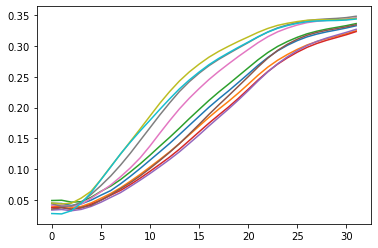

In [11]:
plt.plot(np.array(losses_mae).T)

In [110]:
es = []
for _ in tqdm(range(256)):
    es.append(sliced_wasserstein(a, b, 1024))

100%|██████████| 256/256 [00:19<00:00, 13.15it/s]


In [140]:
np.mean(emds, axis=1)

array([0.24440796, 0.2161412 ])

In [ ]:

d = 32
ts = [32,30,28,25,20,16,8,4,2,1]

clstm_losses_mae = np.zeros((d, len(ts)))


for j, t in enumerate(ts):
    print('Depth:', d, 'Time-step:', t)
    model = getModel(nn.DataParallel(modules.CLSTM(1,64, directional=1)),
                      folder='../models/weights/chaotic',
                      model_file=f'CLSTM_t{t}_d{d}').to(device)
    y_trues, y_preds = getYTruePredPairs(model, dataset, batch_size=8, depth=d, time_steps=t)

    #loss_emd = getLossPerDepth(y_trues, y_preds, criterion=mae_b, max_depth=d)


    clstm_losses_mae[:,j] = loss_mae

    
np.save('clstm_losses_mae_chaos', clstm_losses_mae)

/home/roland/Projekte/Masterthesis/Reconstructing3D/data/evaluation/mae_concentric_CLSTM.npy


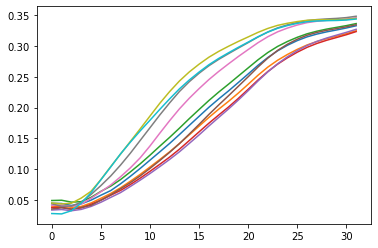

/home/roland/Projekte/Masterthesis/Reconstructing3D/data/evaluation/mae_chaotic_STLSTM.npy


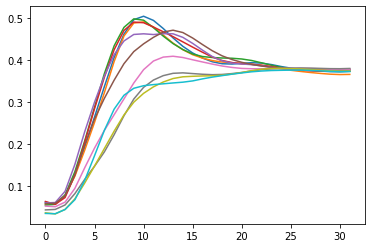

/home/roland/Projekte/Masterthesis/Reconstructing3D/data/evaluation/mae_chaotic_CLSTM.npy


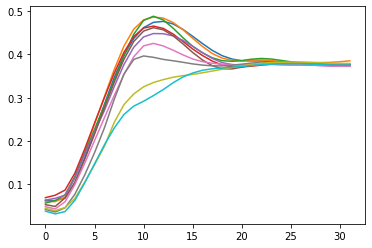

/home/roland/Projekte/Masterthesis/Reconstructing3D/data/evaluation/emd_concentric_STLSTM.npy


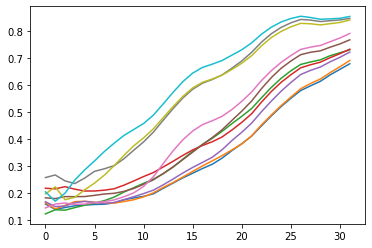

/home/roland/Projekte/Masterthesis/Reconstructing3D/data/evaluation/emd_concentric_CLSTM.npy


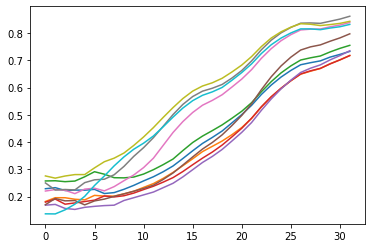

/home/roland/Projekte/Masterthesis/Reconstructing3D/data/evaluation/mae_concentric_STLSTM.npy


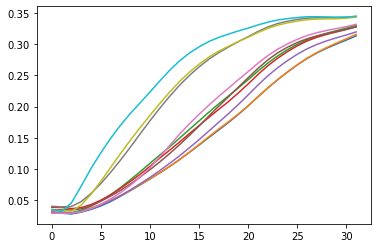

/home/roland/Projekte/Masterthesis/Reconstructing3D/data/evaluation/emd_chaotic_STLSTM.npy


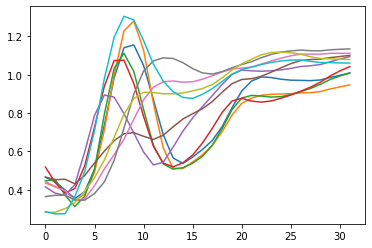

/home/roland/Projekte/Masterthesis/Reconstructing3D/data/evaluation/emd_chaotic_CLSTM.npy


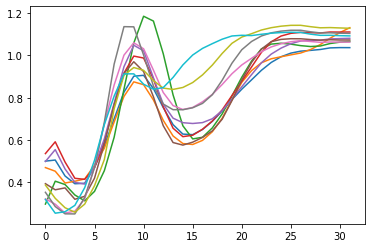

In [10]:
folder = '/home/roland/Projekte/Masterthesis/Reconstructing3D/data/evaluation/'
files = glob.glob(folder + '*.npy')

for file in files:
    print(file)
    d = np.load(file)
    plt.plot(d.T)
    plt.show()


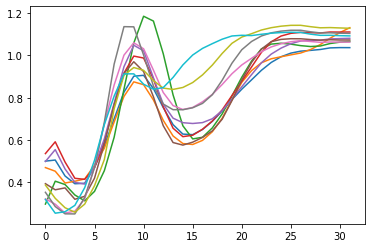

In [8]:
plt.plot(d.T)